In [ ]:
from google.colab import drive
drive.mount('/content/drive')

!pip install -q tensorflow matplotlib seaborn scikit-learn opencv-python

import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
img_size = 150
labels = ['PNEUMONIA', 'NORMAL']

train_dir = '/content/drive/MyDrive/x-ray/chest_xray/train'
val_dir = '/content/drive/MyDrive/x-ray/chest_xray/val'
test_dir = '/content/drive/MyDrive/x-ray/chest_xray/test'

def get_data(data_dir):
    images = []
    labels_list = []
    for label in labels:
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                resized_arr = cv2.resize(img_arr, (img_size, img_size))
                images.append(resized_arr)
                labels_list.append(class_num)
            except:
                continue
    return np.array(images), np.array(labels_list)

x_train, y_train = get_data(train_dir)
x_val, y_val = get_data(val_dir)
x_test, y_test = get_data(test_dir)


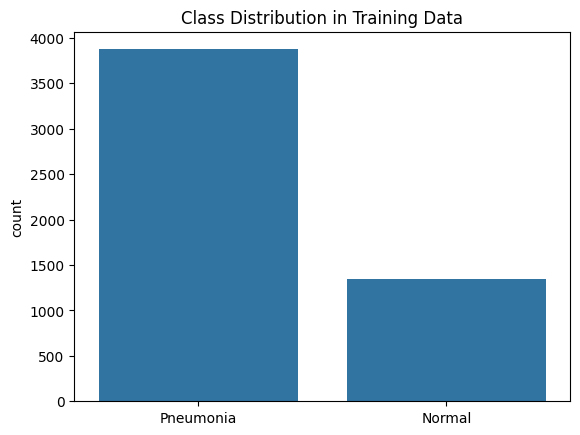

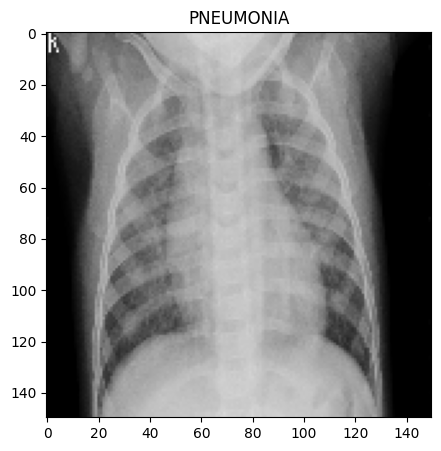

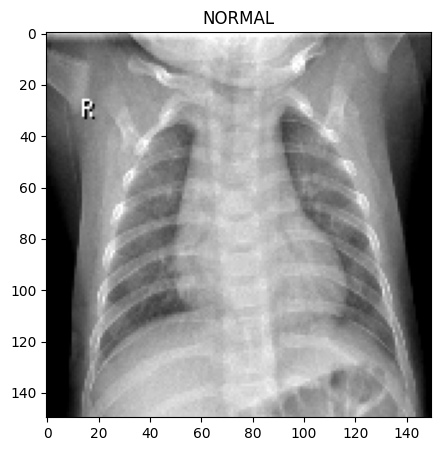

In [ ]:
l = ["Pneumonia" if label == 0 else "Normal" for label in y_train]
sns.countplot(x=l)
plt.title("Class Distribution in Training Data")
plt.show()

plt.figure(figsize=(5,5))
plt.imshow(x_train[0], cmap='gray')
plt.title(labels[y_train[0]])
plt.show()

plt.figure(figsize=(5,5))
plt.imshow(x_train[-1], cmap='gray')
plt.title(labels[y_train[-1]])
plt.show()

x_train = x_train / 255.0
x_val = x_val / 255.0
x_test = x_test / 255.0

x_train = x_train.reshape(-1, img_size, img_size, 1)
x_val = x_val.reshape(-1, img_size, img_size, 1)
x_test = x_test.reshape(-1, img_size, img_size, 1)


In [ ]:
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weight_dict = dict(enumerate(class_weights))

datagen = ImageDataGenerator(
    rotation_range=30,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)
datagen.fit(x_train)


In [ ]:
model = Sequential([
    Conv2D(32, (3,3), padding='same', activation='relu', input_shape=(img_size, img_size, 1)),
    BatchNormalization(),
    MaxPool2D((2,2), padding='same'),

    Conv2D(64, (3,3), padding='same', activation='relu'),
    Dropout(0.1),
    BatchNormalization(),
    MaxPool2D((2,2), padding='same'),

    Conv2D(64, (3,3), padding='same', activation='relu'),
    BatchNormalization(),
    MaxPool2D((2,2), padding='same'),

    Conv2D(128, (3,3), padding='same', activation='relu'),
    Dropout(0.2),
    BatchNormalization(),
    MaxPool2D((2,2), padding='same'),

    Conv2D(256, (3,3), padding='same', activation='relu'),
    Dropout(0.2),
    BatchNormalization(),
    MaxPool2D((2,2), padding='same'),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer="rmsprop", loss='binary_crossentropy', metrics=['accuracy'])

lr_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience=2, verbose=1, factor=0.3, min_lr=1e-6)

history = model.fit(
    datagen.flow(x_train, y_train, batch_size=32),
    validation_data=datagen.flow(x_val, y_val),
    epochs=12,
    callbacks=[lr_reduction],
    class_weight=class_weight_dict
)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/12


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


163/163 ━━━━━━━━━━━━━━━━━━━━ 533s 3s/step - accuracy: 0.7774 - loss: 1.5586 - val_accuracy: 0.5000 - val_loss: 35.2873 - learning_rate: 0.0010
Epoch 2/12
163/163 ━━━━━━━━━━━━━━━━━━━━ 542s 3s/step - accuracy: 0.8519 - loss: 0.3637 - val_accuracy: 0.5000 - val_loss: 110.6080 - learning_rate: 0.0010
Epoch 3/12
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8950 - loss: 0.2879
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
163/163 ━━━━━━━━━━━━━━━━━━━━ 534s 3s/step - accuracy: 0.8950 - loss: 0.2879 - val_accuracy: 0.5000 - val_loss: 30.3857 - learning_rate: 0.0010
Epoch 4/12
163/163 ━━━━━━━━━━━━━━━━━━━━ 564s 3s/step - accuracy: 0.9301 - loss: 0.1944 - val_accuracy: 0.5000 - val_loss: 27.0259 - learning_rate: 3.0000e-04
Epoch 5/12
163/163 ━━━━━━━━━━━━━━━━━━━━ 540s 3s/step - accuracy: 0.9455 - loss: 0.1551 - val_accuracy: 0.6875 - val_loss: 0.5759 - learning_rate: 3.0000e-04
Epoch 6/12
163/163 ━━━━━━━━━━━━━━━━━━━━ 550s 3s/step - accuracy: 0.9477 - loss: 0.1

20/20 ━━━━━━━━━━━━━━━━━━━━ 10s 494ms/step - accuracy: 0.8875 - loss: 0.2911
Test Loss: 0.2678
Test Accuracy: 89.42%


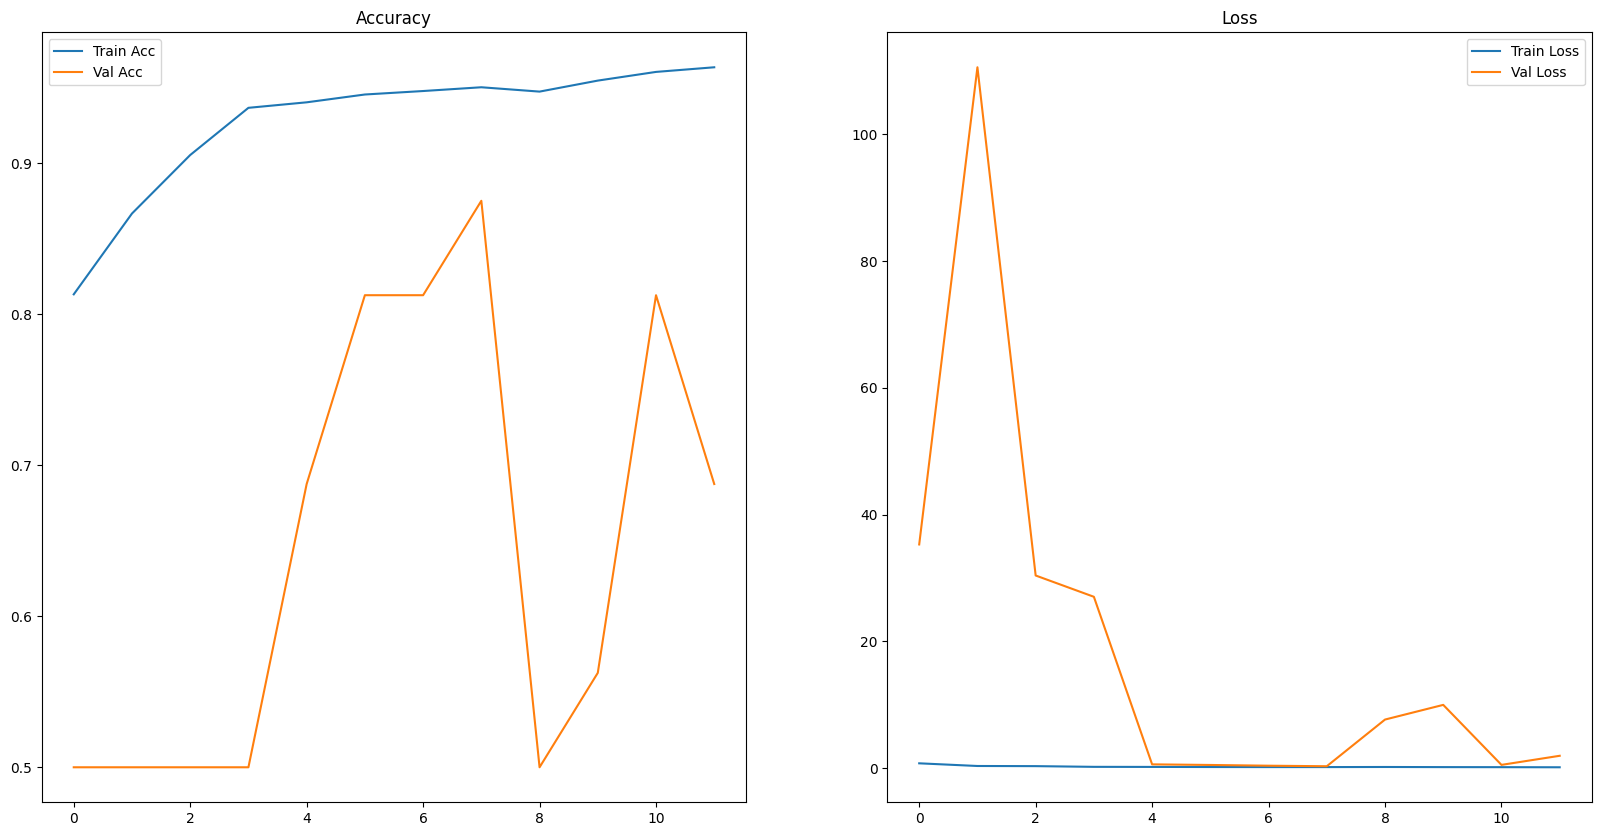

In [ ]:
loss, accuracy = model.evaluate(x_test, y_test)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy*100:.2f}%")

epochs_range = range(12)
fig, ax = plt.subplots(1, 2, figsize=(20, 10))

ax[0].plot(epochs_range, history.history['accuracy'], label='Train Acc')
ax[0].plot(epochs_range, history.history['val_accuracy'], label='Val Acc')
ax[0].set_title('Accuracy')
ax[0].legend()

ax[1].plot(epochs_range, history.history['loss'], label='Train Loss')
ax[1].plot(epochs_range, history.history['val_loss'], label='Val Loss')
ax[1].set_title('Loss')
ax[1].legend()

plt.show()


20/20 ━━━━━━━━━━━━━━━━━━━━ 9s 450ms/step
                     precision    recall  f1-score   support

Pneumonia (Class 0)       0.93      0.90      0.91       390
   Normal (Class 1)       0.84      0.89      0.86       234

           accuracy                           0.89       624
          macro avg       0.88      0.89      0.89       624
       weighted avg       0.90      0.89      0.89       624



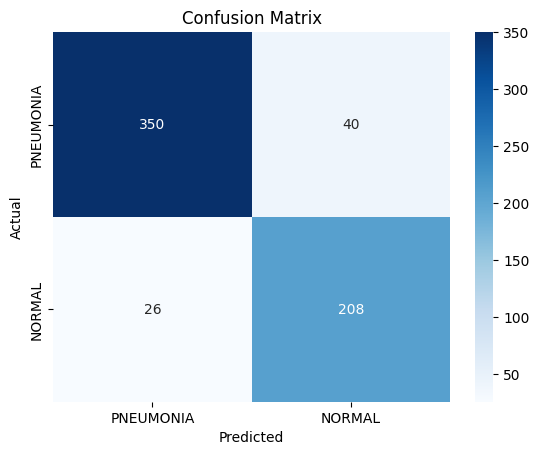

In [9]:
predictions = (model.predict(x_test) > 0.5).astype("int32")
print(classification_report(y_test, predictions, target_names=['Pneumonia (Class 0)', 'Normal (Class 1)']))

cm = confusion_matrix(y_test, predictions)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


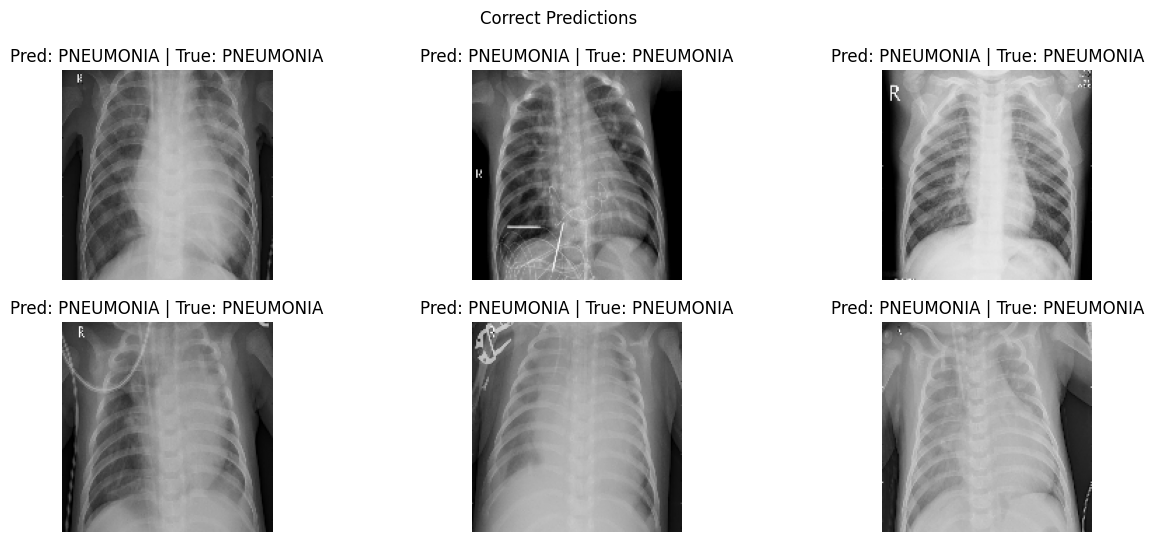

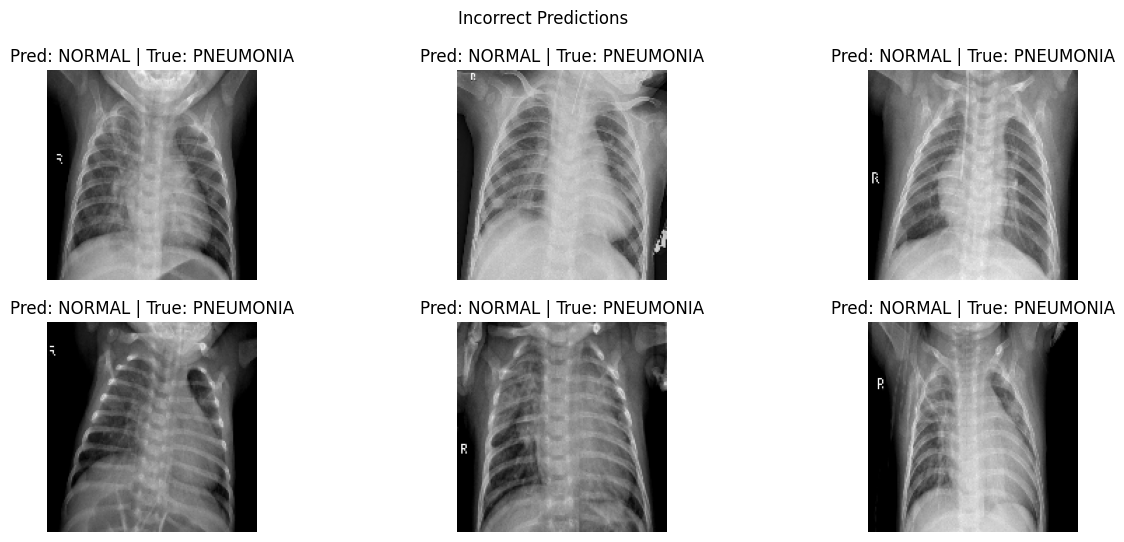

In [10]:
correct = np.nonzero(predictions.flatten() == y_test)[0]
incorrect = np.nonzero(predictions.flatten() != y_test)[0]

plt.figure(figsize=(15, 6))
for i, idx in enumerate(correct[:6]):
    plt.subplot(2, 3, i+1)
    plt.imshow(x_test[idx].reshape(img_size, img_size), cmap='gray')
    plt.title(f"Pred: {labels[predictions[idx][0]]} | True: {labels[y_test[idx]]}")
    plt.axis('off')
plt.suptitle('Correct Predictions')
plt.show()

plt.figure(figsize=(15, 6))
for i, idx in enumerate(incorrect[:6]):
    plt.subplot(2, 3, i+1)
    plt.imshow(x_test[idx].reshape(img_size, img_size), cmap='gray')
    plt.title(f"Pred: {labels[predictions[idx][0]]} | True: {labels[y_test[idx]]}")
    plt.axis('off')
plt.suptitle('Incorrect Predictions')
plt.show()


In [ ]:
def predict_pneumonia(img_path):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (img_size, img_size))
    img = img / 255.0
    img = img.reshape(1, img_size, img_size, 1)
    prediction = model.predict(img)
    return "NORMAL" if prediction[0][0] > 0.5 else "PNEUMONIA"


result = predict_pneumonia('/content/drive/MyDrive/x-ray/chest_xray/test/PNEUMONIA/person91_bacteria_447.jpeg')
print("Prediction:", result)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
Prediction: PNEUMONIA


In [12]:
h5_path = '/content/drive/MyDrive/x-ray/chest_xray/models/CNN_pneumonia_model.h5'
model.save(h5_path)
print(f"Model saved to H5 at: {h5_path}")

Model saved to H5 at: /content/drive/MyDrive/x-ray/chest_xray/models/CNN_pneumonia_model.h5


In [13]:
import pickle

pkl_path = '/content/drive/MyDrive/x-ray/chest_xray/models/CNN_pneumonia_model.pkl'
with open(pkl_path, 'wb') as f:
    pickle.dump(model, f)
print(f"Model pickled at: {pkl_path}")

Model pickled at: /content/drive/MyDrive/x-ray/chest_xray/models/CNN_pneumonia_model.pkl
